# HAR LSTM training 

In [1]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

# def standardize(train, test):
# 	""" Standardize data """

# 	# Standardize train and test
# 	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# 	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

# 	return X_train, X_test

# def one_hot(labels, n_class = 6):
# 	""" One-hot encoding """
# 	expansion = np.eye(n_class)
# 	y = expansion[:, labels-1].T
# 	assert y.shape[1] == n_class, "Wrong number of labels!"

# 	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

## Prepare data

In [2]:
Xtrain, Ytrain, list_ch_train = read_data(data_path="/home/arasdar/datasets/har-data/", split="train") # train
Xtest, Ytest, list_ch_test = read_data(data_path="/home/arasdar/datasets/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
# # Standardize
# X_train, X_test = standardize(X_train, X_test)
# print(X_train.shape, X_test.shape)

Train/Validation Split

In [4]:
from sklearn.model_selection import train_test_split

Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, stratify = Ytrain, random_state = 123)

In [5]:
print(Xtrain.shape, Xtrain.dtype)
print(Xvalid.shape, Xvalid.dtype)
print(Xtest.shape, Xtest.dtype)
print(Ytrain.shape, Ytrain.dtype)
print(Yvalid.shape, Yvalid.dtype)
print(Ytest.shape, Ytest.dtype)

(5514, 128, 9) float64
(1838, 128, 9) float64
(2947, 128, 9) float64
(5514,) int64
(1838,) int64
(2947,) int64


One-hot encoding:

In [6]:
# y_tr = one_hot(lab_tr)
# y_vld = one_hot(lab_vld)
# y_test = one_hot(labels_test)

### Hyperparameters

In [7]:
# Imports
import tensorflow as tf

lstm_size = 27         # 3 times the amount of channels
lstm_layers = 1        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
# graph = tf.Graph()

# Construct placeholders
# with graph.as_default():
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
indices_ = tf.placeholder(tf.int32, [None], name = 'indices')
#     keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
#     learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [9]:
# with graph.as_default():
# Construct the LSTM inputs and LSTM cells
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)
print(len(lstm_in), lstm_in[0].shape)

# Add LSTM layers
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#     drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.contrib.rnn.MultiRNNCell([lstm] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

(?, 128, 9)
(128, ?, 9)
(?, 9)
128 (?, 9)


Define forward pass, cost function and optimizer:

In [10]:
# with graph.as_default():
# with tf.variable_scope('RNN', reuse=True):
outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
labels = tf.one_hot(depth=n_classes, indices=indices_)

# Loss/cost using labels and logits
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))

# Accuracy using logits and labels
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Optimize using loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) # No grad clipping

In [11]:
print(len(outputs), outputs[0].shape)

128 (600, 27)


In [12]:
print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [13]:
print(logits)

Tensor("logits/BiasAdd:0", shape=(600, 6), dtype=float32)


### Train the network

In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
valid_acc, valid_loss = [], []
train_acc, train_loss = [], []

# with graph.as_default():
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the global variable instead of loading them or if there is nothing to load.
    sess.run(tf.global_variables_initializer())
    
    #     # Restore
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #     saver.restore(sess,"checkpoints/har-lstm.ckpt")
    
    for e in range(epochs):
        
        # Loop over training batches
        state = sess.run(initial_state)
        train_acc_batch, train_loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xtrain, Ytrain, batch_size):
            
            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, state, acc, _ = sess.run([cost, final_state, accuracy, optimizer], feed_dict)
            train_acc_batch.append(acc)
            train_loss_batch.append(loss)
            
        # Print at each epoch/iteration
        print("Epoch: {}/{}".format(e, epochs),
              "Train loss: {}".format(np.mean(train_loss_batch)),
              "Train acc: {}".format(np.mean(train_acc_batch)))

        # Store at each epoch/iteration
        train_loss.append(np.mean(train_loss_batch))
        train_acc.append(np.mean(train_acc_batch))
        
        # Loop over validation batches
        state = sess.run(initial_state)
        valid_acc_batch, valid_loss_batch = [], []
        for Xbatch, Ybatch in get_batches(Xvalid, Yvalid, batch_size):
            
            # Feed dictionary
            feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
            loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
            valid_acc_batch.append(acc)
            valid_loss_batch.append(loss)
            
        # Print at each epoch/iteration
        print("Epoch: {}/{}".format(e, epochs),
              "Valid loss: {}".format(np.mean(valid_loss_batch)),
              "Valid acc: {}".format(np.mean(valid_acc_batch)))

        # Store at each epoch/iteration
        valid_loss.append(np.mean(valid_loss_batch))
        valid_acc.append(np.mean(valid_acc_batch))
            
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Train loss: 1.439217448234558 Train acc: 0.1461111158132553
Epoch: 0/1000 Valid loss: 1.4121150970458984 Valid acc: 0.1505555510520935
Epoch: 1/1000 Train loss: 1.3941774368286133 Train acc: 0.19925925135612488
Epoch: 1/1000 Valid loss: 1.3711084127426147 Valid acc: 0.25333333015441895
Epoch: 2/1000 Train loss: 1.3531736135482788 Train acc: 0.2812963128089905
Epoch: 2/1000 Valid loss: 1.3281340599060059 Valid acc: 0.30444446206092834
Epoch: 3/1000 Train loss: 1.3050353527069092 Train acc: 0.3361111283302307
Epoch: 3/1000 Valid loss: 1.2717067003250122 Valid acc: 0.3611111342906952
Epoch: 4/1000 Train loss: 1.2444381713867188 Train acc: 0.3409259021282196
Epoch: 4/1000 Valid loss: 1.2054648399353027 Valid acc: 0.3188888728618622
Epoch: 5/1000 Train loss: 1.191493272781372 Train acc: 0.3248148262500763
Epoch: 5/1000 Valid loss: 1.1501469612121582 Valid acc: 0.35500001907348633
Epoch: 6/1000 Train loss: 1.1383728981018066 Train acc: 0.3714815080165863
Epoch: 6/1000 Valid los

Epoch: 55/1000 Train loss: 0.5331711173057556 Train acc: 0.6379629969596863
Epoch: 55/1000 Valid loss: 0.5382387042045593 Valid acc: 0.620555579662323
Epoch: 56/1000 Train loss: 0.5319458842277527 Train acc: 0.6281481981277466
Epoch: 56/1000 Valid loss: 0.5405706763267517 Valid acc: 0.6333333253860474
Epoch: 57/1000 Train loss: 0.5184677243232727 Train acc: 0.6370370388031006
Epoch: 57/1000 Valid loss: 0.536198079586029 Valid acc: 0.6377777457237244
Epoch: 58/1000 Train loss: 0.5206047892570496 Train acc: 0.6320370435714722
Epoch: 58/1000 Valid loss: 0.5214328765869141 Valid acc: 0.6383333206176758
Epoch: 59/1000 Train loss: 0.5073747038841248 Train acc: 0.6412963271141052
Epoch: 59/1000 Valid loss: 0.5114033818244934 Valid acc: 0.6277777552604675
Epoch: 60/1000 Train loss: 0.49829113483428955 Train acc: 0.6348148584365845
Epoch: 60/1000 Valid loss: 0.5188214182853699 Valid acc: 0.6194444298744202
Epoch: 61/1000 Train loss: 0.49408209323883057 Train acc: 0.6355555057525635
Epoch: 61/10

Epoch: 109/1000 Train loss: 0.428823858499527 Train acc: 0.6794444918632507
Epoch: 109/1000 Valid loss: 0.4246574640274048 Valid acc: 0.6644444465637207
Epoch: 110/1000 Train loss: 0.4099773168563843 Train acc: 0.6835185289382935
Epoch: 110/1000 Valid loss: 0.41836681962013245 Valid acc: 0.662777841091156
Epoch: 111/1000 Train loss: 0.40657010674476624 Train acc: 0.6774073839187622
Epoch: 111/1000 Valid loss: 0.41456320881843567 Valid acc: 0.6827778220176697
Epoch: 112/1000 Train loss: 0.3896823823451996 Train acc: 0.7042592167854309
Epoch: 112/1000 Valid loss: 0.3801058232784271 Valid acc: 0.6944444179534912
Epoch: 113/1000 Train loss: 0.3911307752132416 Train acc: 0.6899999976158142
Epoch: 113/1000 Valid loss: 0.3841873109340668 Valid acc: 0.708888828754425
Epoch: 114/1000 Train loss: 0.38506701588630676 Train acc: 0.7000000476837158
Epoch: 114/1000 Valid loss: 0.4211454391479492 Valid acc: 0.6566666960716248
Epoch: 115/1000 Train loss: 0.36878976225852966 Train acc: 0.70166665315628

Epoch: 163/1000 Train loss: 0.30120792984962463 Train acc: 0.7222222089767456
Epoch: 163/1000 Valid loss: 0.30210360884666443 Valid acc: 0.7172222137451172
Epoch: 164/1000 Train loss: 0.29721754789352417 Train acc: 0.7220370173454285
Epoch: 164/1000 Valid loss: 0.30955013632774353 Valid acc: 0.7166666984558105
Epoch: 165/1000 Train loss: 0.29151424765586853 Train acc: 0.729629635810852
Epoch: 165/1000 Valid loss: 0.3152804970741272 Valid acc: 0.7194444537162781
Epoch: 166/1000 Train loss: 0.324637234210968 Train acc: 0.7209258675575256
Epoch: 166/1000 Valid loss: 0.34714579582214355 Valid acc: 0.726111114025116
Epoch: 167/1000 Train loss: 0.3126879036426544 Train acc: 0.7214815020561218
Epoch: 167/1000 Valid loss: 0.2922121286392212 Valid acc: 0.7211111187934875
Epoch: 168/1000 Train loss: 0.2866678535938263 Train acc: 0.730555534362793
Epoch: 168/1000 Valid loss: 0.28572750091552734 Valid acc: 0.7205556035041809
Epoch: 169/1000 Train loss: 0.2762206792831421 Train acc: 0.7268518805503

Epoch: 216/1000 Train loss: 0.20826596021652222 Train acc: 0.7474074363708496
Epoch: 216/1000 Valid loss: 0.20724010467529297 Valid acc: 0.7522222399711609
Epoch: 217/1000 Train loss: 0.19963914155960083 Train acc: 0.7551851868629456
Epoch: 217/1000 Valid loss: 0.20715992152690887 Valid acc: 0.742222249507904
Epoch: 218/1000 Train loss: 0.19782716035842896 Train acc: 0.7527778148651123
Epoch: 218/1000 Valid loss: 0.21448923647403717 Valid acc: 0.7511110901832581
Epoch: 219/1000 Train loss: 0.1976996511220932 Train acc: 0.7537037134170532
Epoch: 219/1000 Valid loss: 0.20469433069229126 Valid acc: 0.7516667246818542
Epoch: 220/1000 Train loss: 0.19498318433761597 Train acc: 0.7555555105209351
Epoch: 220/1000 Valid loss: 0.2071903944015503 Valid acc: 0.7450000643730164
Epoch: 221/1000 Train loss: 0.19583790004253387 Train acc: 0.7529630064964294
Epoch: 221/1000 Valid loss: 0.20646969974040985 Valid acc: 0.7511110901832581
Epoch: 222/1000 Train loss: 0.21817567944526672 Train acc: 0.741481

Epoch: 269/1000 Train loss: 0.21292699873447418 Train acc: 0.7464814782142639
Epoch: 269/1000 Valid loss: 0.21697567403316498 Valid acc: 0.746666669845581
Epoch: 270/1000 Train loss: 0.2250206172466278 Train acc: 0.745185136795044
Epoch: 270/1000 Valid loss: 0.21996231377124786 Valid acc: 0.7450000643730164
Epoch: 271/1000 Train loss: 0.20616605877876282 Train acc: 0.7518518567085266
Epoch: 271/1000 Valid loss: 0.20858478546142578 Valid acc: 0.7461110949516296
Epoch: 272/1000 Train loss: 0.19782087206840515 Train acc: 0.7546296715736389
Epoch: 272/1000 Valid loss: 0.2010239213705063 Valid acc: 0.7433333396911621
Epoch: 273/1000 Train loss: 0.1991795003414154 Train acc: 0.7490741014480591
Epoch: 273/1000 Valid loss: 0.20371027290821075 Valid acc: 0.7472222447395325
Epoch: 274/1000 Train loss: 0.19324201345443726 Train acc: 0.7529629468917847
Epoch: 274/1000 Valid loss: 0.1987677812576294 Valid acc: 0.7511110901832581
Epoch: 275/1000 Train loss: 0.1874217689037323 Train acc: 0.7538888454

Epoch: 323/1000 Train loss: 1.1336055994033813 Train acc: 0.31888890266418457
Epoch: 323/1000 Valid loss: 1.0364800691604614 Valid acc: 0.37555554509162903
Epoch: 324/1000 Train loss: 1.129337191581726 Train acc: 0.3318518400192261
Epoch: 324/1000 Valid loss: 1.022961974143982 Valid acc: 0.3838888704776764
Epoch: 325/1000 Train loss: 1.113398790359497 Train acc: 0.3431481122970581
Epoch: 325/1000 Valid loss: 1.0060656070709229 Valid acc: 0.4011111259460449
Epoch: 326/1000 Train loss: 1.0932228565216064 Train acc: 0.3583333492279053
Epoch: 326/1000 Valid loss: 0.988635241985321 Valid acc: 0.41555556654930115
Epoch: 327/1000 Train loss: 1.0755470991134644 Train acc: 0.36888885498046875
Epoch: 327/1000 Valid loss: 0.9711413383483887 Valid acc: 0.4238888919353485
Epoch: 328/1000 Train loss: 1.0616800785064697 Train acc: 0.37518519163131714
Epoch: 328/1000 Valid loss: 0.9581975936889648 Valid acc: 0.4372222125530243
Epoch: 329/1000 Train loss: 1.0470157861709595 Train acc: 0.394629657268524

Epoch: 377/1000 Train loss: 0.7953236699104309 Train acc: 0.48759257793426514
Epoch: 377/1000 Valid loss: 0.6740068793296814 Valid acc: 0.5550000071525574
Epoch: 378/1000 Train loss: 0.7945846319198608 Train acc: 0.47870370745658875
Epoch: 378/1000 Valid loss: 0.6699879765510559 Valid acc: 0.5538888573646545
Epoch: 379/1000 Train loss: 0.7900533676147461 Train acc: 0.48277774453163147
Epoch: 379/1000 Valid loss: 0.6701188683509827 Valid acc: 0.5483333468437195
Epoch: 380/1000 Train loss: 0.7898905277252197 Train acc: 0.47611114382743835
Epoch: 380/1000 Valid loss: 0.6669893264770508 Valid acc: 0.5488888621330261
Epoch: 381/1000 Train loss: 0.7855724692344666 Train acc: 0.4788888692855835
Epoch: 381/1000 Valid loss: 0.6643224358558655 Valid acc: 0.5444445013999939
Epoch: 382/1000 Train loss: 0.7850549817085266 Train acc: 0.47462961077690125
Epoch: 382/1000 Valid loss: 0.6640737652778625 Valid acc: 0.545555591583252
Epoch: 383/1000 Train loss: 0.7816681265830994 Train acc: 0.478888869285

Epoch: 431/1000 Train loss: 0.7208846211433411 Train acc: 0.4914814531803131
Epoch: 431/1000 Valid loss: 0.5875482559204102 Valid acc: 0.5716666579246521
Epoch: 432/1000 Train loss: 0.7200897336006165 Train acc: 0.4905555546283722
Epoch: 432/1000 Valid loss: 0.5877103209495544 Valid acc: 0.573888897895813
Epoch: 433/1000 Train loss: 0.7192955613136292 Train acc: 0.49111106991767883
Epoch: 433/1000 Valid loss: 0.586671769618988 Valid acc: 0.5716666579246521
Epoch: 434/1000 Train loss: 0.7185659408569336 Train acc: 0.4905555546283722
Epoch: 434/1000 Valid loss: 0.586219072341919 Valid acc: 0.5733333230018616
Epoch: 435/1000 Train loss: 0.7176691889762878 Train acc: 0.49129629135131836
Epoch: 435/1000 Valid loss: 0.5847830772399902 Valid acc: 0.5733333230018616
Epoch: 436/1000 Train loss: 0.7169529795646667 Train acc: 0.49074071645736694
Epoch: 436/1000 Valid loss: 0.58393794298172 Valid acc: 0.5722222328186035
Epoch: 437/1000 Train loss: 0.7160841822624207 Train acc: 0.49166664481163025


Epoch: 485/1000 Train loss: 0.6815128326416016 Train acc: 0.4987036883831024
Epoch: 485/1000 Valid loss: 0.5355488657951355 Valid acc: 0.6016666889190674
Epoch: 486/1000 Train loss: 0.6798474788665771 Train acc: 0.5025925636291504
Epoch: 486/1000 Valid loss: 0.5519639849662781 Valid acc: 0.5916666388511658
Epoch: 487/1000 Train loss: 0.6899694204330444 Train acc: 0.4977777898311615
Epoch: 487/1000 Valid loss: 0.5455074310302734 Valid acc: 0.5955555438995361
Epoch: 488/1000 Train loss: 0.6867789030075073 Train acc: 0.5014815330505371
Epoch: 488/1000 Valid loss: 0.5433763861656189 Valid acc: 0.5994444489479065
Epoch: 489/1000 Train loss: 0.6839325428009033 Train acc: 0.504444420337677
Epoch: 489/1000 Valid loss: 0.5435495972633362 Valid acc: 0.5938888192176819
Epoch: 490/1000 Train loss: 0.6835095882415771 Train acc: 0.5012962818145752
Epoch: 490/1000 Valid loss: 0.5342867374420166 Valid acc: 0.6022222638130188
Epoch: 491/1000 Train loss: 0.6802146434783936 Train acc: 0.5046296715736389


Epoch: 539/1000 Train loss: 0.651494562625885 Train acc: 0.5190740823745728
Epoch: 539/1000 Valid loss: 0.4897121489048004 Valid acc: 0.6322221755981445
Epoch: 540/1000 Train loss: 0.6561161279678345 Train acc: 0.5125925540924072
Epoch: 540/1000 Valid loss: 0.4946676790714264 Valid acc: 0.6138889193534851
Epoch: 541/1000 Train loss: 0.6550871133804321 Train acc: 0.5181481838226318
Epoch: 541/1000 Valid loss: 0.49000048637390137 Valid acc: 0.6255555152893066
Epoch: 542/1000 Train loss: 0.6542200446128845 Train acc: 0.5124073624610901
Epoch: 542/1000 Valid loss: 0.4933806359767914 Valid acc: 0.6150000095367432
Epoch: 543/1000 Train loss: 0.6552783846855164 Train acc: 0.5162962675094604
Epoch: 543/1000 Valid loss: 0.4900777041912079 Valid acc: 0.6311111450195312
Epoch: 544/1000 Train loss: 0.6516011357307434 Train acc: 0.5151851773262024
Epoch: 544/1000 Valid loss: 0.4796799123287201 Valid acc: 0.6300000548362732
Epoch: 545/1000 Train loss: 0.6472436785697937 Train acc: 0.5222222208976746

Epoch: 593/1000 Train loss: 0.6266059875488281 Train acc: 0.5255555510520935
Epoch: 593/1000 Valid loss: 0.4307337999343872 Valid acc: 0.6505555510520935
Epoch: 594/1000 Train loss: 0.6213807463645935 Train acc: 0.5288888812065125
Epoch: 594/1000 Valid loss: 0.4276951849460602 Valid acc: 0.6566666960716248
Epoch: 595/1000 Train loss: 0.6191907525062561 Train acc: 0.5296295881271362
Epoch: 595/1000 Valid loss: 0.42487093806266785 Valid acc: 0.6622222065925598
Epoch: 596/1000 Train loss: 0.6199426054954529 Train acc: 0.5305555462837219
Epoch: 596/1000 Valid loss: 0.42595699429512024 Valid acc: 0.6577777862548828
Epoch: 597/1000 Train loss: 0.6154909729957581 Train acc: 0.5311111211776733
Epoch: 597/1000 Valid loss: 0.4213719069957733 Valid acc: 0.6600000262260437
Epoch: 598/1000 Train loss: 0.6132333278656006 Train acc: 0.5324074029922485
Epoch: 598/1000 Valid loss: 0.4172758162021637 Valid acc: 0.6605556011199951
Epoch: 599/1000 Train loss: 0.6111084222793579 Train acc: 0.53314816951751

Epoch: 647/1000 Train loss: 0.5692867636680603 Train acc: 0.5555555820465088
Epoch: 647/1000 Valid loss: 0.3556157648563385 Valid acc: 0.6766667366027832
Epoch: 648/1000 Train loss: 0.5644025802612305 Train acc: 0.5562962293624878
Epoch: 648/1000 Valid loss: 0.353325217962265 Valid acc: 0.6788888573646545
Epoch: 649/1000 Train loss: 0.5548644065856934 Train acc: 0.5677778124809265
Epoch: 649/1000 Valid loss: 0.3564217984676361 Valid acc: 0.6700000166893005
Epoch: 650/1000 Train loss: 0.5572366714477539 Train acc: 0.5638888478279114
Epoch: 650/1000 Valid loss: 0.3581978380680084 Valid acc: 0.6738888621330261
Epoch: 651/1000 Train loss: 0.5696380138397217 Train acc: 0.5555555820465088
Epoch: 651/1000 Valid loss: 0.3746929466724396 Valid acc: 0.6627777814865112
Epoch: 652/1000 Train loss: 0.5090468525886536 Train acc: 0.5968518853187561
Epoch: 652/1000 Valid loss: 0.36805638670921326 Valid acc: 0.67166668176651
Epoch: 653/1000 Train loss: 0.4995803236961365 Train acc: 0.6087037920951843
E

Epoch: 700/1000 Train loss: 0.211237832903862 Train acc: 0.7549999952316284
Epoch: 700/1000 Valid loss: 0.20707309246063232 Valid acc: 0.75
Epoch: 701/1000 Train loss: 0.212612122297287 Train acc: 0.7448147535324097
Epoch: 701/1000 Valid loss: 0.2149425595998764 Valid acc: 0.742222249507904
Epoch: 702/1000 Train loss: 0.2079842984676361 Train acc: 0.7540740966796875
Epoch: 702/1000 Valid loss: 0.202168807387352 Valid acc: 0.7549999356269836
Epoch: 703/1000 Train loss: 0.21270082890987396 Train acc: 0.745185136795044
Epoch: 703/1000 Valid loss: 0.20651914179325104 Valid acc: 0.7394444346427917
Epoch: 704/1000 Train loss: 0.20117676258087158 Train acc: 0.753333330154419
Epoch: 704/1000 Valid loss: 0.1989242285490036 Valid acc: 0.7522222399711609
Epoch: 705/1000 Train loss: 0.19692747294902802 Train acc: 0.7546296119689941
Epoch: 705/1000 Valid loss: 0.1930071860551834 Valid acc: 0.757777750492096
Epoch: 706/1000 Train loss: 0.18624360859394073 Train acc: 0.7579629421234131
Epoch: 706/100

Epoch: 753/1000 Train loss: 0.16589045524597168 Train acc: 0.7629629969596863
Epoch: 753/1000 Valid loss: 0.17287921905517578 Valid acc: 0.7594444155693054
Epoch: 754/1000 Train loss: 0.17074531316757202 Train acc: 0.7624074220657349
Epoch: 754/1000 Valid loss: 0.1735808104276657 Valid acc: 0.7583333849906921
Epoch: 755/1000 Train loss: 0.17110970616340637 Train acc: 0.762592613697052
Epoch: 755/1000 Valid loss: 0.16656307876110077 Valid acc: 0.7622222304344177
Epoch: 756/1000 Train loss: 0.16071659326553345 Train acc: 0.761296272277832
Epoch: 756/1000 Valid loss: 0.16156870126724243 Valid acc: 0.7605555653572083
Epoch: 757/1000 Train loss: 0.15558625757694244 Train acc: 0.7648147940635681
Epoch: 757/1000 Valid loss: 0.1618305742740631 Valid acc: 0.7605555653572083
Epoch: 758/1000 Train loss: 0.15907156467437744 Train acc: 0.7618518471717834
Epoch: 758/1000 Valid loss: 0.16063253581523895 Valid acc: 0.7616665959358215
Epoch: 759/1000 Train loss: 0.15697436034679413 Train acc: 0.7657406

Epoch: 806/1000 Train loss: 0.4896481931209564 Train acc: 0.613703727722168
Epoch: 806/1000 Valid loss: 0.3725484311580658 Valid acc: 0.6538888812065125
Epoch: 807/1000 Train loss: 0.5032153129577637 Train acc: 0.6135185360908508
Epoch: 807/1000 Valid loss: 0.40095949172973633 Valid acc: 0.6505555510520935
Epoch: 808/1000 Train loss: 0.521941065788269 Train acc: 0.601111114025116
Epoch: 808/1000 Valid loss: 0.4042418897151947 Valid acc: 0.6388888955116272
Epoch: 809/1000 Train loss: 0.5086212158203125 Train acc: 0.604259192943573
Epoch: 809/1000 Valid loss: 0.374026894569397 Valid acc: 0.6572222113609314
Epoch: 810/1000 Train loss: 0.48952925205230713 Train acc: 0.6174074411392212
Epoch: 810/1000 Valid loss: 0.35815557837486267 Valid acc: 0.6688888669013977
Epoch: 811/1000 Train loss: 0.4172666072845459 Train acc: 0.6520370841026306
Epoch: 811/1000 Valid loss: 0.32767125964164734 Valid acc: 0.6833333373069763
Epoch: 812/1000 Train loss: 0.36286771297454834 Train acc: 0.6718518733978271

Epoch: 859/1000 Train loss: 0.607643187046051 Train acc: 0.570555567741394
Epoch: 859/1000 Valid loss: 0.3577791154384613 Valid acc: 0.6700000166893005
Epoch: 860/1000 Train loss: 0.5372017621994019 Train acc: 0.5948148369789124
Epoch: 860/1000 Valid loss: 0.3066484034061432 Valid acc: 0.694444477558136
Epoch: 861/1000 Train loss: 0.34916117787361145 Train acc: 0.6837036609649658
Epoch: 861/1000 Valid loss: 0.26862862706184387 Valid acc: 0.708888828754425
Epoch: 862/1000 Train loss: 0.32407715916633606 Train acc: 0.6935184597969055
Epoch: 862/1000 Valid loss: 0.25875720381736755 Valid acc: 0.7099999785423279
Epoch: 863/1000 Train loss: 0.32756394147872925 Train acc: 0.6874074339866638
Epoch: 863/1000 Valid loss: 0.2722291052341461 Valid acc: 0.7088889479637146
Epoch: 864/1000 Train loss: 0.3243650197982788 Train acc: 0.6879629492759705
Epoch: 864/1000 Valid loss: 0.25012871623039246 Valid acc: 0.7122222781181335
Epoch: 865/1000 Train loss: 0.2901071310043335 Train acc: 0.70222222805023

Epoch: 912/1000 Train loss: 0.22725582122802734 Train acc: 0.7262963056564331
Epoch: 912/1000 Valid loss: 0.19909392297267914 Valid acc: 0.730555534362793
Epoch: 913/1000 Train loss: 0.22625930607318878 Train acc: 0.7246296405792236
Epoch: 913/1000 Valid loss: 0.20102627575397491 Valid acc: 0.731666624546051
Epoch: 914/1000 Train loss: 0.2267981320619583 Train acc: 0.7268518805503845
Epoch: 914/1000 Valid loss: 0.19979526102542877 Valid acc: 0.7377777695655823
Epoch: 915/1000 Train loss: 0.2260264754295349 Train acc: 0.7244444489479065
Epoch: 915/1000 Valid loss: 0.19982945919036865 Valid acc: 0.7238888740539551
Epoch: 916/1000 Train loss: 0.22645919024944305 Train acc: 0.7238889336585999
Epoch: 916/1000 Valid loss: 0.20061051845550537 Valid acc: 0.7372221946716309
Epoch: 917/1000 Train loss: 0.22497953474521637 Train acc: 0.7268518805503845
Epoch: 917/1000 Valid loss: 0.2010573148727417 Valid acc: 0.7288889288902283
Epoch: 918/1000 Train loss: 0.2251555621623993 Train acc: 0.725925922

Epoch: 965/1000 Train loss: 0.16067558526992798 Train acc: 0.7651851773262024
Epoch: 965/1000 Valid loss: 0.15644027292728424 Valid acc: 0.7572221755981445
Epoch: 966/1000 Train loss: 0.16048887372016907 Train acc: 0.764629602432251
Epoch: 966/1000 Valid loss: 0.15615308284759521 Valid acc: 0.7566666603088379
Epoch: 967/1000 Train loss: 0.15939487516880035 Train acc: 0.764629602432251
Epoch: 967/1000 Valid loss: 0.15661810338497162 Valid acc: 0.7561111450195312
Epoch: 968/1000 Train loss: 0.1589042991399765 Train acc: 0.7644444704055786
Epoch: 968/1000 Valid loss: 0.1565864086151123 Valid acc: 0.7599999904632568
Epoch: 969/1000 Train loss: 0.1602926105260849 Train acc: 0.765740692615509
Epoch: 969/1000 Valid loss: 0.1607852727174759 Valid acc: 0.757777750492096
Epoch: 970/1000 Train loss: 0.16128191351890564 Train acc: 0.7653703689575195
Epoch: 970/1000 Valid loss: 0.16101345419883728 Valid acc: 0.7583333849906921
Epoch: 971/1000 Train loss: 0.163651242852211 Train acc: 0.7631481289863

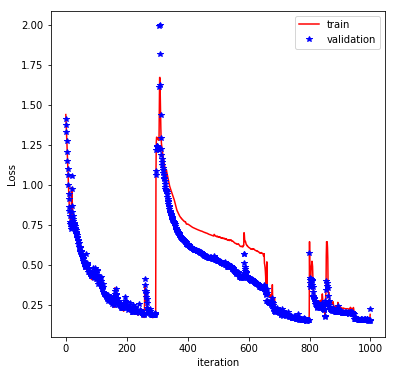

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and test loss
plt.figure(figsize = (6,6))
plt.plot(np.array(train_loss), 'r-', np.array(valid_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

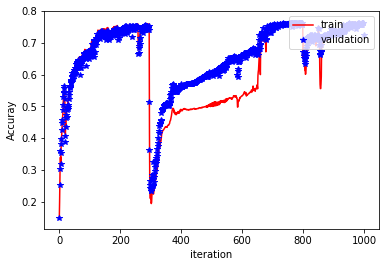

In [17]:
# Plot Accuracies
plt.plot(np.array(train_acc), 'r-', valid_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [18]:
loss, acc = [], []

with tf.Session() as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    # Loop over test batches
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []
    for Xbatch, Ybatch in get_batches(Xtest, Ytest, batch_size):

        # Feed dictionary
        feed_dict = {inputs_: Xbatch, indices_: Ybatch, initial_state: state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print at each epoch/iteration
    print("Epoch: {}/{}".format(e, epochs),
          "Test loss: {}".format(np.mean(loss_batch)),
          "Test acc: {}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 999/1000 Test loss: 0.5031494498252869 Test acc: 0.6679166555404663
